_A note on coordinate frames:_ I use a double-underscore to indicate coordinate frame, so `up__phone` is the up direction in the phone's local reference frame. For transforms, the convention `__to__from` is used, so `R__mag_enu__phone` is the rotation to apply to coordinates in the phone frame to transform them into the magnetic east-north-up frame.

In [1]:
import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import utm
import transformations as tf
from math import pi, sin, cos
import shapely
import geojson
import json
import simplekml
from magnetic_field_calculator import MagneticFieldCalculator
import matplotlib.pyplot as plt
import pymap3d
from pycontrails.physics import geo, units
from PIL import Image, ExifTags
import tempfile
import datetime

from google.cloud import bigquery, storage

In [2]:
client = bigquery.Client()
storage_client = storage.Client("contrails-observer")
bucket = storage_client.get_bucket("contrails-observer.appspot.com")
photo_id = '1AvV2US8OtRNWAG92WTG'

FLIGHT_LEVELS = [
    200,
    210,
    220,
    230,
    240,
    250,
    260,
    270,
    280,
    290,
    300,
    310,
    320,
    330,
    340,
    350,
    360,
    370,
    380,
    390,
    400,
    410,
    420,
    430,
    440,
]

In [3]:
with open("camera_calibration.p", "rb") as cal_infile:
    calibration = pickle.load(cal_infile)

Premature end of JPEG file


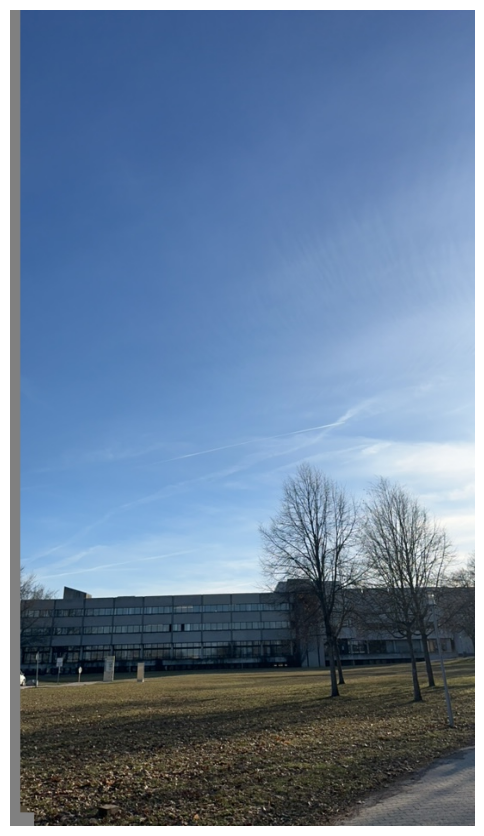

In [4]:
with tempfile.NamedTemporaryFile() as tmp:
    blob = bucket.blob(photo_id)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(6,10.6))
    img_color = cv.imread(tmp.name)
    ax.imshow(img_color[...,::-1],aspect='auto')
    ax.set_axis_off()

In [5]:
# Force the optical center of the image to be the center of the camera matrix
ny, nx, _ = img_color.shape
calibration['cam_matrix'][0,2] = nx/2.0
calibration['cam_matrix'][1,2] = ny/2.0

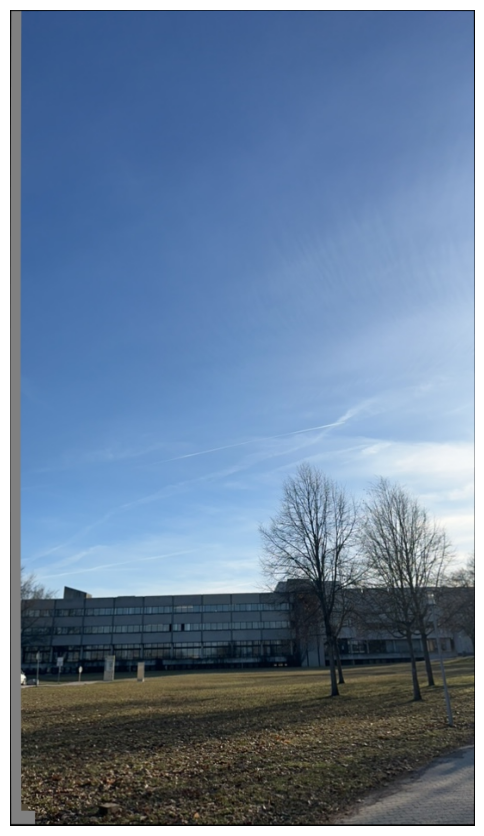

In [6]:
fig, ax = plt.subplots(1,figsize=(6,10.6))
i2 = cv.undistort(img_color,calibration['cam_matrix'],calibration['distortion_coeffs'])
ax.imshow(i2[...,::-1],aspect='auto')
ax.set_axis_off()

In [7]:
# Get photo polygons from big query
QUERY = (
    'SELECT timestamp, latitude, longitude, magnetometer, accelerometer, altitude, model FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{photo_id}"')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
photo_info = ra[0]

In [8]:
photo_info.timestamp

datetime.datetime(2024, 2, 5, 14, 14, 49, 250000, tzinfo=datetime.timezone.utc)

# Phone position and orientation

First, we read the positioning sensors to reconstruct the reference frame of the phone

In [9]:
acceleration = np.array([
    [photo_info.accelerometer[0]['x']], 
    [photo_info.accelerometer[0]['y']], 
    [photo_info.accelerometer[0]['z']]]
)
magnetometer = np.array([
    [photo_info.magnetometer[0]['x']], 
    [photo_info.magnetometer[0]['y']], 
    [photo_info.magnetometer[0]['z']]]
)
# at rest, observed acceleration is up
up__phone = acceleration / np.linalg.norm(acceleration)

# magnetic field points north (note that this differs from the physics convention)
H__phone = magnetometer / np.linalg.norm(magnetometer)

# Apple multiplies the accelerometer by g (-9.81) so we need to correct the signs
if 'iPhone' in photo_info.model:
    up__phone *= -1
    H__phone *= -1

In [10]:
up__phone

array([[ 0.03906663],
       [ 0.89687524],
       [-0.44055488]])

In [11]:
H__phone

array([[-0.89200189],
       [ 0.15336095],
       [ 0.42522117]])

## Getting camera pose from sensor data

In [12]:
location = {'latitude': photo_info.latitude, 'longitude': photo_info.longitude, 'altitude': photo_info.altitude}
location_utm = utm.from_latlon(location['latitude'], location['longitude'])

# Get magnetic declination for current location
mag_calc = MagneticFieldCalculator()
mag_data = mag_calc.calculate(
    latitude=-location['latitude'],
    longitude=location['longitude'],
    altitude=location['altitude'],
    date='2020-12-31' # This doesn't really matter as long as it's not a hundred years in the past or something
)

In [13]:
# construct east-north-up frame
mag_east__phone = np.cross(H__phone, up__phone, 0, 0, 0)
mag_east__phone = mag_east__phone / np.linalg.norm(mag_east__phone)
mag_north__phone = np.cross(up__phone, mag_east__phone, 0, 0, 0)
mag_north__phone = mag_north__phone / np.linalg.norm(mag_north__phone)

R__phone__mag_enu = np.hstack((mag_east__phone, mag_north__phone, up__phone))
R__mag_enu__phone = R__phone__mag_enu.T

declination = mag_data['field-value']['declination']['value'] * pi / 180 # sign of declination is reversed to make it a right-hand rotation around up

R__enu__mag_enu = np.array([[cos(declination), -sin(declination), 0],
                            [sin(declination),  cos(declination), 0],
                            [               0,                 0, 1]])

R__enu__phone = R__enu__mag_enu @ R__mag_enu__phone



phone_pose__enu = np.block([
    [R__enu__phone, np.array([[location_utm[0]], [location_utm[1]], [location['altitude']]])],
    [np.array([[0, 0, 0, 1]])]
])

# Android phone coordinate frame is defined here:
#    https://developer.android.com/guide/topics/sensors/sensors_overview#sensors-coords
# Looking at the screen, with the phone in portrait orientation:
#  - X is to the right
#  - Y is up
#  - Z is coming out of the screen

# Nominal rotation from camera frame (right-down-forward) to phone frame (right-up-backward)
# The true rotation is likely different. This is a source of error. An extrinsic calibration would be necessary to
# measure this error.
R__phone__cam = np.array([[ 1,  0,  0],
                          [ 0, -1,  0],
                          [ 0,  0, -1]])

# The camera pose is the transform from camera coords (right-down-forward) to world coords (east-north-up)
T__enu__cam = np.block([
    [R__enu__phone @ R__phone__cam, np.array([[location_utm[0]], [location_utm[1]], [location['altitude']]])],
    [np.array([[0, 0, 0, 1]])]
])

print("Camera principle axis (ENU):", T__enu__cam[:3, 2])

Camera principle axis (ENU): [ 0.53784977 -0.7187691   0.44055488]


### Lazy way to find coords above horizon

Note: in this example the photo length of the camera is way off so it looks like the entire photo is above the horizon. 
The az/el at the center of the photo is fairly accurate however

In [14]:
# Produce cartesean product of photo coordinates
x_px = nx
y_px = ny
x = np.arange(0,x_px) 
y = np.arange(0,y_px) 
pts__img = np.dstack(np.meshgrid(x, y)).reshape(-1, 2).astype('float')

# Apply undistortion - essentially a low-order polynomial correction to model lens flare
# Also add homogeneous coordiante
pts__undistorted_img = cv.undistortImagePoints(pts__img.T, calibration['cam_matrix'], calibration['distortion_coeffs'])[:,0,:]
pts__undistorted_img = np.hstack((pts__undistorted_img,np.ones((pts__undistorted_img.shape[0],1))))

# Back project using camera matrix - these are now rays pointing towards the camera principal point
rays__cam = np.linalg.inv(calibration['cam_matrix']) @ pts__undistorted_img.T

# Rotate from camera (up,right,forward) to world (east, north, up) and normalize so we have unit vectors
rays__enu = T__enu__cam[:3,:3] @ rays__cam
rays__enu /= np.linalg.norm(rays__enu,axis=0)

# unit vectors to get az/el
north = np.array([[0],[1],[0]])
up = np.array([[0],[0],[1]])

# "elevation" is degrees away from zenith
el = np.arccos(np.dot(up.T,rays__enu))

el_mask = (el < units.degrees_to_radians(80)).reshape((y_px,x_px))

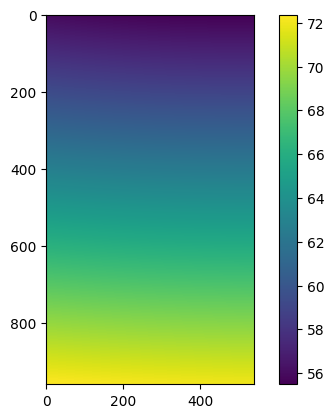

In [15]:
plt.imshow(units.radians_to_degrees(el.reshape((y_px,x_px))))
plt.colorbar()

In [16]:
# Find boundary of the portions of the photo above the horizon, then simply polygon and get verticies
contours = cv.findContours(el_mask.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = np.squeeze(contours[0])
polygon = shapely.Polygon(contour)
polygon = polygon.simplify(1)
verticies = list(polygon.exterior.coords)

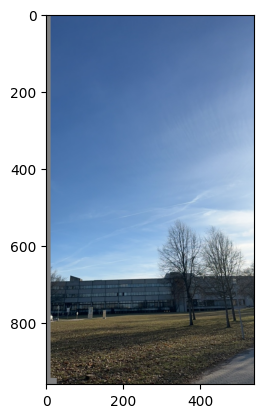

In [17]:
i3 = np.copy(img_color)
m3 = np.repeat(np.expand_dims(el_mask,2),3,2)
i3[np.bitwise_not(m3)]=0
plt.imshow(i3[:,:,::-1])

## Now find flight levels in photos

Each flight level is simply a plane in projective space. 
We previously found the bounds of the photo that are above the horizon.
We can construct a ray that passes from the camera aperature (origin of our projective space) to the point of the image plane that contains these verticies.
Then we can find the intersection between this ray and the plane that represents each flight level.

In [18]:
# back-project using the camera matrix
P = np.hstack((calibration['cam_matrix'], np.array([[0], [0], [0]])))
pinv_P = np.linalg.pinv(P)

polygons = []
for fl in FLIGHT_LEVELS:
    # plane at flight level
    altitude_m = units.ft_to_m(fl*100)
    altitude_plane__enu = np.array([[0], [0], [1], [-altitude_m]])
    
    vert_list__gps = []
    for vert__img in verticies:
        # undistort, and add homogeneous coordinate
        vert__undistorted_img = np.append(
            cv.undistortImagePoints(vert__img, calibration['cam_matrix'],
                                    calibration['distortion_coeffs']).reshape((2, 1)),
            np.array([[1]]), axis=0)
        
        vert__cam = pinv_P @ vert__undistorted_img
        camera_center__cam = np.array([[0], [0], [0], [1]])
        
        # Represent rays using Plücker matrices. See Hartley & Zisserman, section 3.2.2, page 70, or Wikipedia:
        #  https://en.wikipedia.org/wiki/Pl%C3%BCcker_matrix
        vert_ray__cam = vert__cam @ camera_center__cam.T - \
                         camera_center__cam @ vert__cam.T
    
        # Convert ray from camera to world coordiantes
        vert_ray__enu = T__enu__cam @ vert_ray__cam @ T__enu__cam.T
    
        vert__enu = vert_ray__enu @ altitude_plane__enu
        vert__enu /= vert__enu[-1]
    
        vert__gps = utm.to_latlon(vert__enu[0], vert__enu[1], location_utm[2], location_utm[3])
    
        vert_list__gps.append((vert__gps[1][0],vert__gps[0][0]))

    pg = dict(geojson.Polygon(vert_list__gps))
    pg['coordinates'] = [pg['coordinates']]
    j = {
        "type": "Feature",
        "properties": {
            "level":fl,
            "id":"4T1oAksxnNU25hGrkAFV"},
        "geometry": pg
    }
    polygons.append(j)


In [19]:
json.dumps({'type':'FeatureCollection', 'features': polygons})

'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"level": 200, "id": "4T1oAksxnNU25hGrkAFV"}, "geometry": {"type": "Polygon", "coordinates": [[[12.178372, 48.947261], [12.265724, 48.88337], [12.230048, 48.869284], [12.159855, 48.938856], [12.178372, 48.947261]]]}}, {"type": "Feature", "properties": {"level": 210, "id": "4T1oAksxnNU25hGrkAFV"}, "geometry": {"type": "Polygon", "coordinates": [[[12.18272, 48.944394], [12.2747, 48.877099], [12.237129, 48.862267], [12.163219, 48.935542], [12.18272, 48.944394]]]}}, {"type": "Feature", "properties": {"level": 220, "id": "4T1oAksxnNU25hGrkAFV"}, "geometry": {"type": "Polygon", "coordinates": [[[12.187068, 48.941526], [12.283673, 48.870828], [12.244208, 48.85525], [12.166583, 48.932228], [12.187068, 48.941526]]]}}, {"type": "Feature", "properties": {"level": 230, "id": "4T1oAksxnNU25hGrkAFV"}, "geometry": {"type": "Polygon", "coordinates": [[[12.191415, 48.938658], [12.292645, 48.864556], [12.251285, 48.848232], [1